# Intro

Welcome to the classifier training notebook!

To run this notebook, you must first have prepared images and labels. This can be done using the `labeling_interactive.ipynb` notebook, or can be provided manually.

The notebook proceeds as follows:
1. **Import** libraries
2. Define **paths** to data
3. **Train** a classifier
4. **Save** results

# Imports

In [38]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
from pathlib import Path
import tempfile
import functools

import numpy as np
import sklearn

In [3]:
%load_ext autoreload
%autoreload 2
import roicat


In [19]:
import matplotlib.pyplot as plt

# Initialize Parameters

In [4]:
directory_save = r'/home/rich/Desktop/'

In [5]:
INTEGER_MAX = np.iinfo(np.int64(0).dtype).max
Path(directory_save).resolve().mkdir(exist_ok=True, parents=True)

# Data Importing

## Option 1: Use Data Results from Labeling Interactive Outputs

##### 1. Specify filepath

In [6]:
filepath_labellingInteractive = r'/home/rich/Desktop/test.ROICaT.labeling.results.pkl'

##### 2. Import data

Be sure to specify a `um_per_pixel`

In [7]:
labelingInteractive = roicat.helpers.pickle_load(filepath_labellingInteractive)

data = roicat.data_importing.Data_roicat();
data.set_ROI_images(
    ROI_images=[labelingInteractive['images'][labelingInteractive['labels']['index']]],
    um_per_pixel=2.0,
);
data.set_class_labels(
    [labelingInteractive['labels']['label']],
);

data.check_completeness()

Starting: Importing ROI images
Completed: Imported 1 sessions. Each session has [30] ROIs. Total number of ROIs is 30. The um_per_pixel is 2.0 um per pixel.
Starting: Importing class labels
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Completed: Imported labels for 1 sessions. Each session has [30] class labels. Total number of class labels is 30.
RH WARNING: Tracking incomplete because the following attributes are missing: ['spatialFootprints', 'FOV_images']
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Cannot check validity of spatialFootprints and FOV_images because one or both do not exist as attributes.
Data_roicat object completeness: {'classification_inference': True, 'classification_training': True, 'tracking': False}


{'classification_inference': True,
 'classification_training': True,
 'tracking': False}

Notice that `.check_completeness()` shows that `classification_training` is `True`

## Option 2: Make a custom data

See the [demo_data_importing](https://github.com/RichieHakim/ROICaT/blob/dev/notebooks/jupyter/other/demo_data_importing.ipynb) notebook to build a custom data object using any kind of data (Suite2p, CaImAn, etc.). It's really easy!

For example:
```
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=['/path/to/stat.npy'],
    paths_opsFiles=['/path/to/ops.npy'],
    um_per_pixel=2.5,  
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)
data.set_class_labels(path_labels=['/path/to/labels.npy'])
assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."
```

In [8]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=['/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/stat.npy'],
    paths_opsFiles=['/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/ops.npy'],
    um_per_pixel=2.5,  
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)

data.set_class_labels(path_labels=['/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy'])

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.
Starting: Importing class labels
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Completed: Imported labels for 1 sessions. Each session has [4898] class labels. Total number of class labels is 4898.


# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

##### 1. Initialize ROInet

Initialize the ROInet object. The `ROInet_embedder` class will automatically download and load a pretrained ROInet model. If you have a GPU, this step will be much faster.

In [9]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/c8m3b/download',  ## URL of the model
    download_hash='357a8d9b630ec79f3e015d0056a4c2d5',  ## Hash of the model file
    forward_pass_version='head',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
    
    jit_script_transforms=False,  ## (advanced) Whether or not to use torch.jit.script to speed things up
    
    batchSize_dataloader=8,  ## (advanced) PyTorch dataloader batch_size
    pinMemory_dataloader=True,  ## (advanced) PyTorch dataloader pin_memory
    numWorkers_dataloader=-1,  ## (advanced) PyTorch dataloader num_workers. -1 is all cores.
    persistentWorkers_dataloader=True,  ## (advanced) PyTorch dataloader persistent_workers
    prefetchFactor_dataloader=2,  ## (advanced) PyTorch dataloader prefetch_factor
);

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)
File already exists locally: /tmp/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /tmp/ROInet.zip to /tmp.
Completed zip extraction.
Imported model from /tmp/ROInet_classification_20220902/model.py
Loaded params_model from /tmp/ROInet_classification_20220902/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /tmp/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


##### 2. Check ROI_images sizes
In general, you want to see that a neuron fills roughly 25-50% of the area of the image. \
**Adjust `um_per_pixel` above to rescale image size**


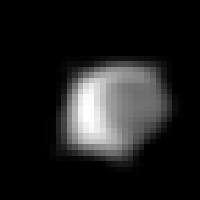

In [10]:
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs[:1000], image_size=(200,200))

##### 3. Pass data through network

Pass the data through the network. Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.

In [11]:
roinet.generate_latents();

starting: running data through network


100%|█████████████████████████████████████████| 613/613 [00:08<00:00, 71.13it/s]


completed: running data through network


# Train / Validation / Test Split Data, Hyperparameter Tune on Validation Set, and Fit Model

In [50]:
X = roinet.latents
y = np.concatenate(data.class_labels)

In [102]:
autoClassifier = roicat.classification.classifier.Auto_LogisticRegression(
    X=X,
    y=y,
    C_bounds=[1e-15, 1e4],
)

In [ ]:
autoClassifier.fit()

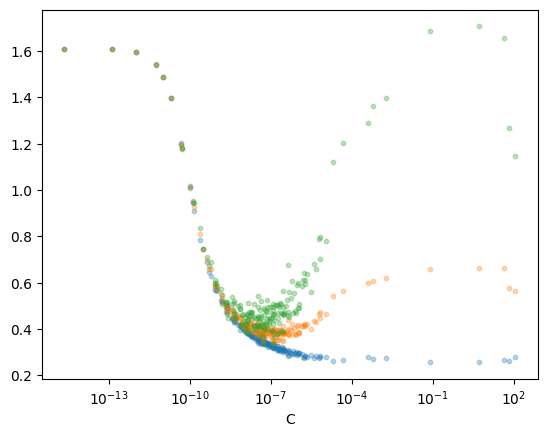

In [89]:
results = {
    'C': [t.params['C'] for t in autoClassifier.study.trials], 
    'value': [t.value for t in autoClassifier.study.trials], 
    'loss_train': autoClassifier.loss_running_train, 
    'loss_test': autoClassifier.loss_running_test
}

plt.figure()
scatter = functools.partial(plt.scatter, x=results['C'], alpha=0.3, s=10)
scatter(y=results['loss_train'])
scatter(y=results['loss_test'])
scatter(y=results['value'])

plt.xlabel('C')
plt.xscale('log')

In [90]:
y_pred = autoClassifier.model_best.predict(X)

In [91]:
roicat.helpers.confusion_matrix(y_true=y, y_hat=y_pred,)

array([[0.89032258, 0.14444444, 0.        , 0.        , 0.        ],
       [0.10967742, 0.77160494, 0.12438119, 0.        , 0.        ],
       [0.        , 0.08271605, 0.80878713, 0.05665281, 0.        ],
       [0.        , 0.        , 0.04888614, 0.93139293, 0.        ],
       [0.        , 0.00123457, 0.01794554, 0.01195426, 1.        ]])

In [92]:
cm = sklearn.metrics.confusion_matrix(y_true=y, y_pred=y_pred, normalize='true', sample_weight=sample_weight).T
cm

array([[0.89032258, 0.14444444, 0.        , 0.        , 0.        ],
       [0.10967742, 0.77160494, 0.12438119, 0.        , 0.        ],
       [0.        , 0.08271605, 0.80878713, 0.05665281, 0.        ],
       [0.        , 0.        , 0.04888614, 0.93139293, 0.        ],
       [0.        , 0.00123457, 0.01794554, 0.01195426, 1.        ]])

In [93]:
sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred, normalize=True, sample_weight=sample_weight)

0.8804215158045139

In [60]:
# TODO: JZ, IMPLEMENT AS LOOP FOR OPTUNA FOR HYPERPARAMETER TUNING
# Create data splitting object for stratified sampling into train and test sets (as well as downsampling)
data_splitter = cu.Datasplit(
    features=roinet.latents.cpu().numpy(),
    labels=np.concatenate(data.class_labels, axis=0),
    n_train=INTEGER_MAX,
    val_size=0.2,
    test_size=0.2,
)

model_sklearn = sklearn.linear_model.LogisticRegression(                    
    solver='lbfgs',                      
    fit_intercept=True,                      
    max_iter=10000,                      
    C=1e5,                      
    class_weight=data_splitter.dict_class_weights)


In [61]:
model_sklearn.fit(data_splitter.features_train, data_splitter.labels_train);

/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
# Create lenet model, associated optimizer, loss function, and training tracker
model = cu.LogisticRegression(coef=model_sklearn.coef_,
                              intercept=model_sklearn.intercept_,
                              model_dict=model_sklearn.__dict__);

In [69]:
assert np.allclose(model_sklearn.predict_proba(data_splitter.features_train), model.predict_proba(data_splitter.features_train)), \
 "JZ: Sklearn and saved models do not agree on prediction for training set. Contact authors for assistance."

In [67]:
print(f'Calculating tracker outputs and saving to {directory_save}...')
training_tracker = cu.ModelResults(
    directory_save=directory_save,
    class_weights=data_splitter.class_weights, # Class Weights
    n_train_actual=data_splitter.n_train_actual,
    model=({'coef':model._coef, 'intercept':model._intercept})
);
model.save_eval(data_splitter, training_tracker);

Calculating tracker outputs and saving to /Users/josh/analysis/outputs/ROICaT/classification/classifier_train...
Saving results:  /Users/josh/analysis/outputs/ROICaT/classification/classifier_train/results_training /Users/josh/analysis/outputs/ROICaT/classification/classifier_train/results_timing.json
self.tictoc={}
self.model={'coef': array([[-2.36333884e-02,  1.24026862e-02,  6.89024065e-02,
         4.06505870e-02, -2.28465066e-03, -8.23994541e-02,
         2.42108959e-02,  7.76038111e-02, -9.61156875e-02,
         3.53588388e-02, -7.30954640e-02,  3.51103147e-02,
         7.50516869e-02, -2.74418999e-02,  3.33038928e-02,
        -1.06890748e-02,  1.50956818e-02,  8.10004979e-02,
         1.30728834e-02, -2.09046471e-02,  1.07470912e-04,
         1.30294823e-02, -5.01405966e-02,  7.05013450e-02,
         5.20106152e-02, -7.47459779e-02, -4.48539508e-02,
        -8.04061055e-02,  1.44353473e-04, -9.34211991e-04,
         3.82589133e-02,  8.88287292e-02,  1.51197973e-02,
         6.43

# Save Outputs

In [57]:
model.save(str((Path(directory_save) / 'model.pkl').resolve()), save_as_serializable_dict=True, allow_overwrite=False,)

print(f'Saved model fit results.')

Saved model fit results.
